In [30]:
!pip install caer canaro

In [31]:
import os
import caer
import canaro
import numpy as np
import cv2 as cv
import gc
import sklearn.model_selection as skm 
#pylint:disable=no-member (Removes linting problems with cv)

In [32]:
IMG_SIZE = (80, 80)
channels = 1
char_path = r'../input/the-simpsons-characters-dataset/simpsons_dataset'

In [33]:
# Creating a character dictionary, sorting it in descending order
char_dict = {}
for char in os.listdir(char_path):
    char_dict[char] = len(os.listdir(os.path.join(char_path,char)))

# Sort in descending order
char_dict = caer.sort_dict(char_dict, descending=True)
char_dict

[('homer_simpson', 2246),
 ('ned_flanders', 1454),
 ('moe_szyslak', 1452),
 ('lisa_simpson', 1354),
 ('bart_simpson', 1342),
 ('marge_simpson', 1291),
 ('krusty_the_clown', 1206),
 ('principal_skinner', 1194),
 ('charles_montgomery_burns', 1193),
 ('milhouse_van_houten', 1079),
 ('chief_wiggum', 986),
 ('abraham_grampa_simpson', 913),
 ('sideshow_bob', 877),
 ('apu_nahasapeemapetilon', 623),
 ('kent_brockman', 498),
 ('comic_book_guy', 469),
 ('edna_krabappel', 457),
 ('nelson_muntz', 358),
 ('lenny_leonard', 310),
 ('mayor_quimby', 246),
 ('waylon_smithers', 181),
 ('maggie_simpson', 128),
 ('groundskeeper_willie', 121),
 ('barney_gumble', 106),
 ('selma_bouvier', 103),
 ('carl_carlson', 98),
 ('ralph_wiggum', 89),
 ('patty_bouvier', 72),
 ('martin_prince', 71),
 ('professor_john_frink', 65),
 ('snake_jailbird', 55),
 ('cletus_spuckler', 47),
 ('rainier_wolfcastle', 45),
 ('simpsons_dataset', 42),
 ('agnes_skinner', 42),
 ('sideshow_mel', 40),
 ('otto_mann', 32),
 ('fat_tony', 27),
 (

In [34]:
#  Getting the first 10 categories with the most number of images
characters = []
count = 0
for i in char_dict:
    characters.append(i[0])
    count += 1
    if count >= 10:
        break
characters

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten']

In [35]:
# Create the training data
train = caer.preprocess_from_dir(char_path, characters, channels=channels, IMG_SIZE=IMG_SIZE, isShuffle=True)

[INFO] Could not find a file to load from. Generating the training data
----------------------------------------------
1 - homer_simpson
2 - homer_simpson
3 - homer_simpson
4 - homer_simpson
5 - homer_simpson
6 - homer_simpson
7 - homer_simpson
8 - homer_simpson
9 - homer_simpson
10 - homer_simpson
11 - homer_simpson
12 - homer_simpson
13 - homer_simpson
14 - homer_simpson
15 - homer_simpson
16 - homer_simpson
17 - homer_simpson
18 - homer_simpson
19 - homer_simpson
20 - homer_simpson
21 - homer_simpson
22 - homer_simpson
23 - homer_simpson
24 - homer_simpson
25 - homer_simpson
26 - homer_simpson
27 - homer_simpson
28 - homer_simpson
29 - homer_simpson
30 - homer_simpson
31 - homer_simpson
32 - homer_simpson
33 - homer_simpson
34 - homer_simpson
35 - homer_simpson
36 - homer_simpson
37 - homer_simpson
38 - homer_simpson
39 - homer_simpson
40 - homer_simpson
41 - homer_simpson
42 - homer_simpson
43 - homer_simpson
44 - homer_simpson
45 - homer_simpson
46 - homer_simpson
47 - homer_simps

/opt/conda/lib/python3.7/site-packages/caer/core.py:72: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(obj, dtype=dtype, order=order)


In [36]:
len(train)

13811

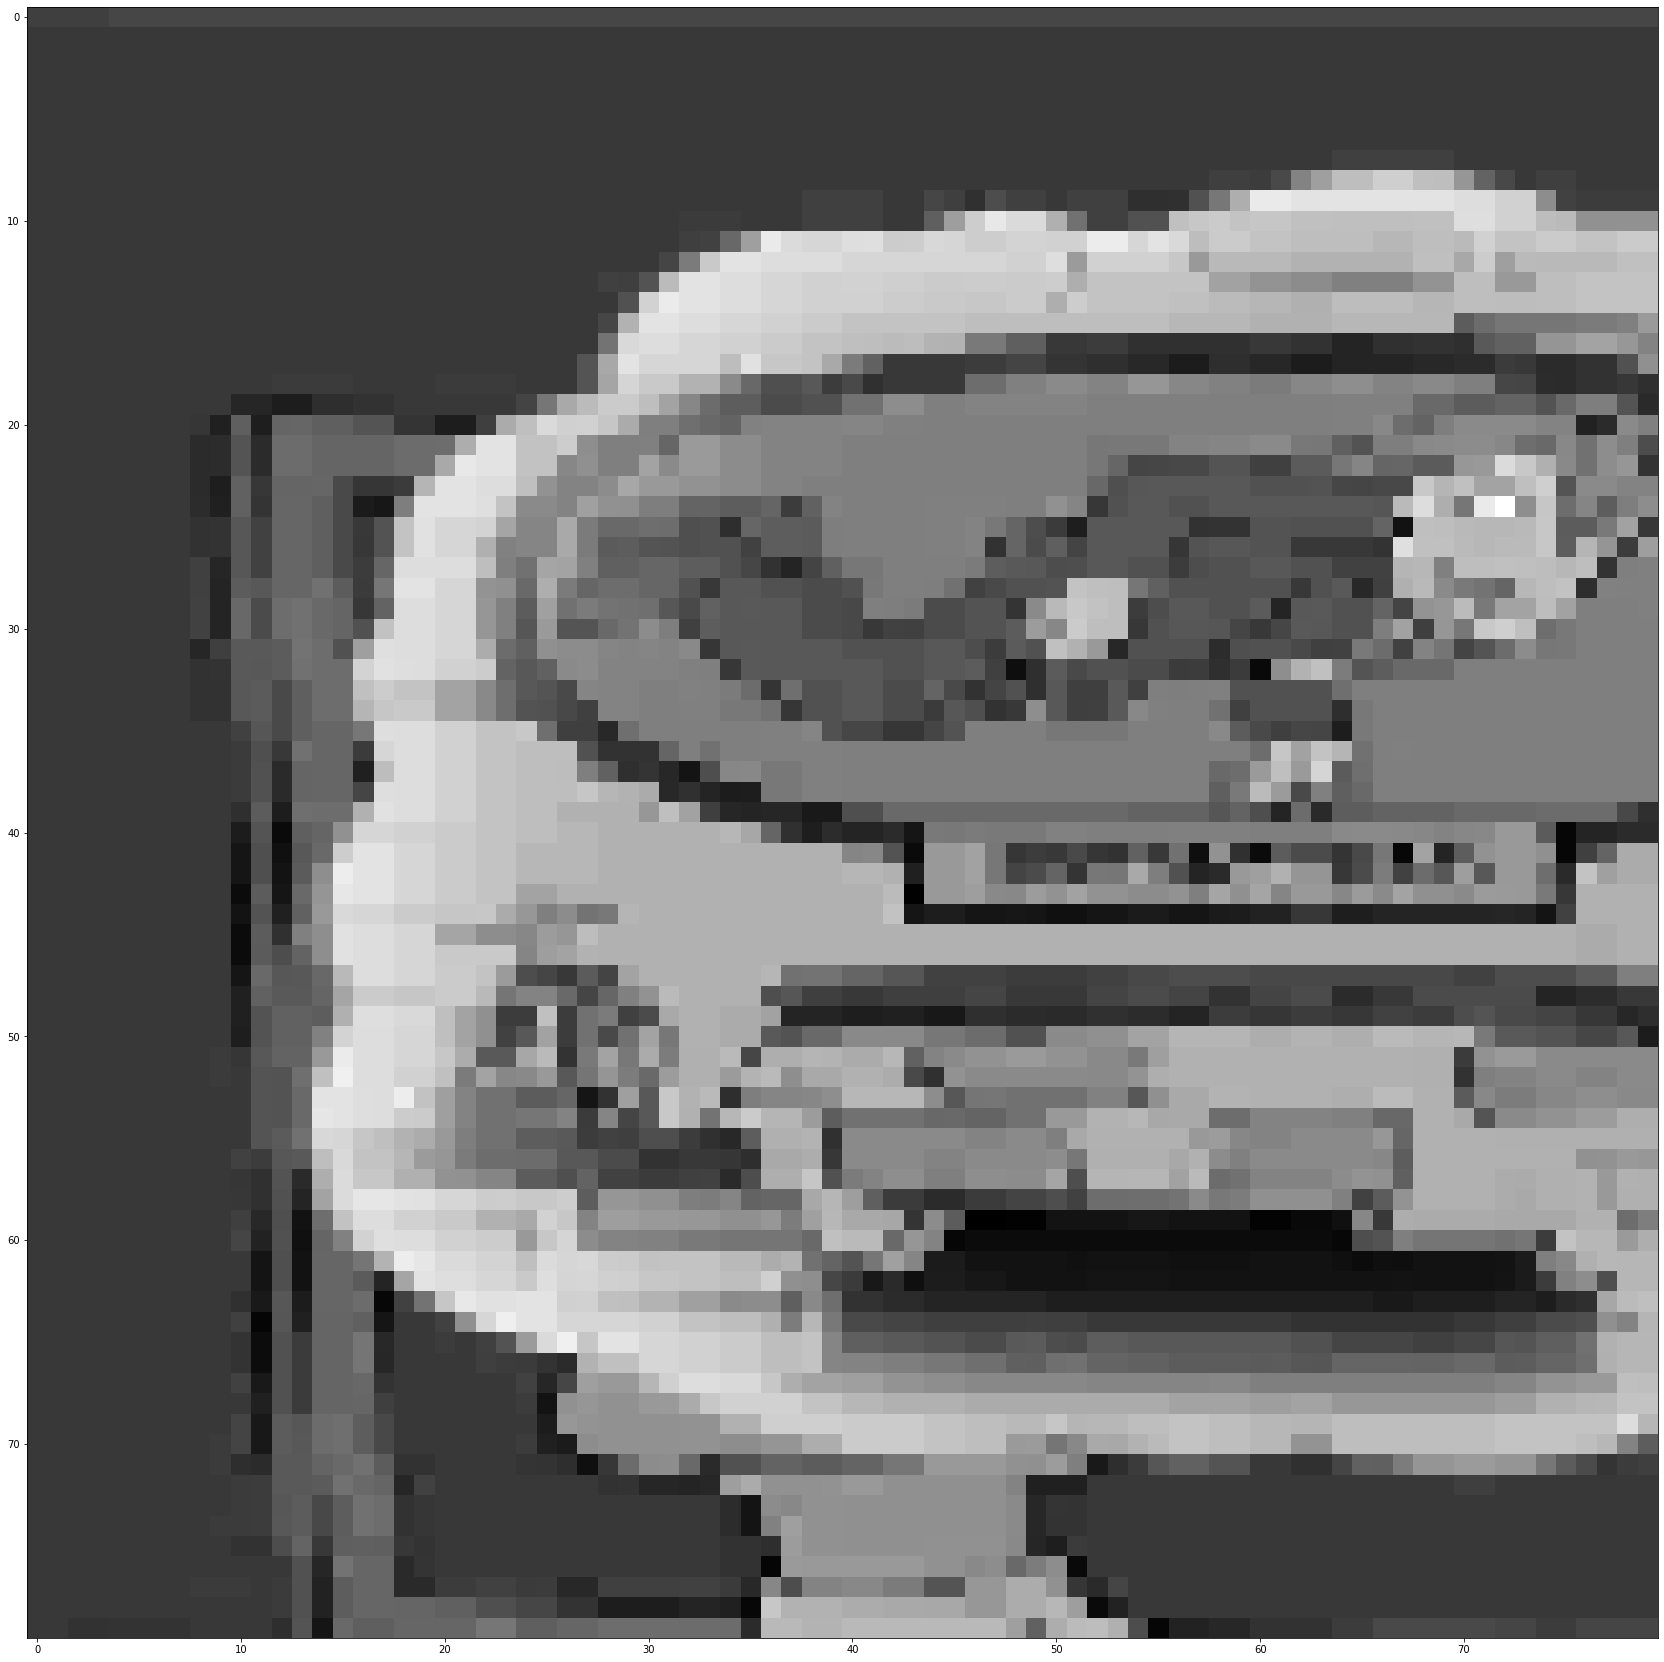

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,30))
plt.imshow(train[0][0], cmap='gray')
plt.show()

In [38]:
# Separating the array and corresponding labels
featureSet, labels = caer.sep_train(train, IMG_SIZE=IMG_SIZE)

In [39]:
from tensorflow.keras.utils import to_categorical

# Normalize the featureSet ==> (0,1)
featureSet = caer.normalize(featureSet)
# Converting numerical labels to binary class vectors
labels = to_categorical(labels, len(characters))

In [40]:
split_data = skm.train_test_split(featureSet, labels, test_size=.2)
x_train, x_val, y_train, y_val = (np.array(item) for item in split_data)

In [41]:
del train
del featureSet
del labels
gc.collect()

3372

In [42]:
BATCH_SIZE = 32
EPOCHS = 10

In [43]:
# Image data generator (introduces randomness in network ==> better accuracy)
datagen = canaro.generators.imageDataGenerator()
train_gen = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)

In [45]:
# Creating the model
model = canaro.models.createSimpsonsModel(IMG_SIZE=IMG_SIZE, channels=channels, output_dim=len(characters), 
                                          loss='binary_crossentropy', decay=1e-6, learning_rate=0.001, momentum=0.9, nesterov=True)

In [46]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 80, 80, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 78, 78, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 39, 39, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 39, 39, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 37, 37, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 18, 64)       

In [47]:
from tensorflow.keras.callbacks import LearningRateScheduler
callbacks_list=[LearningRateScheduler(canaro.lr_schedule)]

In [48]:
training = model.fit(train_gen,
                    steps_per_epoch=len(x_train)//BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(x_val,y_val),
                    validation_steps=len(y_val)//BATCH_SIZE,
                    callbacks=callbacks_list)

Epoch 1/10
345/345 [==============================] - 14s 30ms/step - loss: 0.3864 - accuracy: 0.1394 - val_loss: 0.3314 - val_accuracy: 0.1545
Epoch 2/10
345/345 [==============================] - 10s 29ms/step - loss: 0.3237 - accuracy: 0.1623
Epoch 3/10
345/345 [==============================] - 9s 27ms/step - loss: 0.3230 - accuracy: 0.1718
Epoch 4/10
345/345 [==============================] - 10s 29ms/step - loss: 0.3232 - accuracy: 0.1614
Epoch 5/10
345/345 [==============================] - 10s 29ms/step - loss: 0.3213 - accuracy: 0.1705
Epoch 6/10
345/345 [==============================] - 10s 29ms/step - loss: 0.3117 - accuracy: 0.2030
Epoch 7/10
345/345 [==============================] - 10s 30ms/step - loss: 0.3055 - accuracy: 0.2343
Epoch 8/10
345/345 [==============================] - 11s 31ms/step - loss: 0.3018 - accuracy: 0.2533
Epoch 9/10
345/345 [==============================] - 10s 29ms/step - loss: 0.3007 - accuracy: 0.2592
Epoch 10/10
345/345 [====================

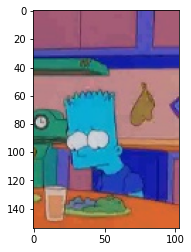

In [60]:
test_path = r"../input/the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset/bart_simpson_22.jpg"
img = cv.imread(test_path)

def prepare(img):
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img = cv.resize(img, IMG_SIZE)
    img = caer.reshape(img, IMG_SIZE, 1)
    return img    

plt.imshow(img)
plt.show()

In [61]:
predictions = model.predict(prepare(img))

In [62]:
predictions

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [63]:
print(characters[np.argmax(predictions[0])])

lisa_simpson
